In [ ]:
! git lfs install
! git clone https://github.com/timojl/clipseg 
! pip install diffusers -q
! pip install transformers -q -UU ftfy gradio  
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip

!pip3 install git+https://github.com/huggingface/diffusers
!pip3 install accelerate
!pip3 install transformers

In [ ]:
!pip3 install git+https://github.com/vltmedia/uaiDiffusers
!pip3 install mediapipe
!pip3 install onnx
!pip3 install onnxruntime
!pip3 install imread-from-url
import os, PIL
import uaiDiffusers.uaiDiffusers as uaiDiffusers 
#import uaiDiffusers.hair as hair 

In [3]:
! pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [12]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
! pwd #showing current directory "/content"

/content


In [5]:
%cd clipseg

/content/clipseg


In [ ]:
# ! ls #showing all files in clipseg folder

In [6]:
#only to bo be run once
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from io import BytesIO
from torch import autocast
import PIL


In [7]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 110MiB/s]


In [10]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('../weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False); #cuda to be replaced by CPU when running locally

In [16]:
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

device = "cuda" #cuda to be replaced by CPU when running locally
pipe = None
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    # "stabilityai/stable-diffusion-1.5-inpainting"
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

# image_url = "/content/drive/MyDrive/ADV9207/selfie_input.jpg" 

# def load_selfie(image_url):
#   img = Image.open(image_url)
#   img = np.array(img)
#   return img

# selfie_image = load_selfie(image_url)


# or load from URL...
image_url = 'https://i.ibb.co/hZQNwrJ/IMG-6757.jpg'

input_image = Image.open(requests.get(image_url, stream=True).raw)
input_image = input_image.convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
%cd ..

/content


In [19]:
input_image.resize((512, 512)).save("init_image.png", "PNG")

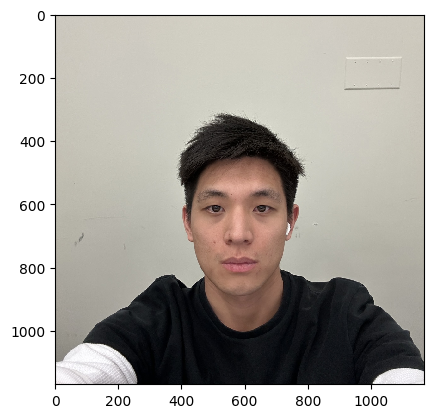

In [20]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [21]:
import numpy as np
import torch
from PIL import Image

from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
! pip3 install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 16.8 MB/s eta 0:00:00


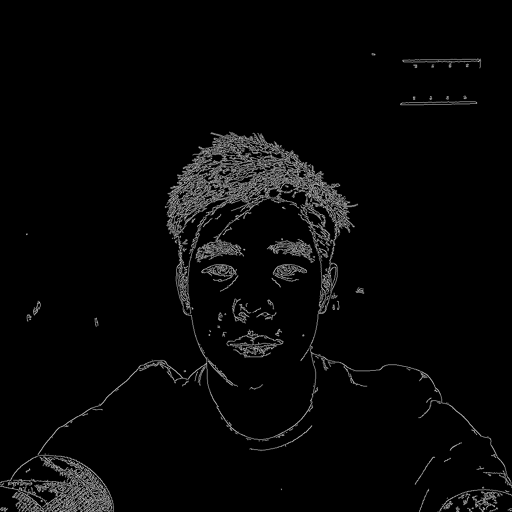

In [27]:
import cv2
from PIL import Image
import numpy as np

image = np.array(input_image)

low_threshold = 100
high_threshold = 40

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

canny_image = canny_image.resize((512, 512))

canny_image

In [28]:
prompts = ['area outside of face']

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]

torch.Size([1, 1, 512, 512])


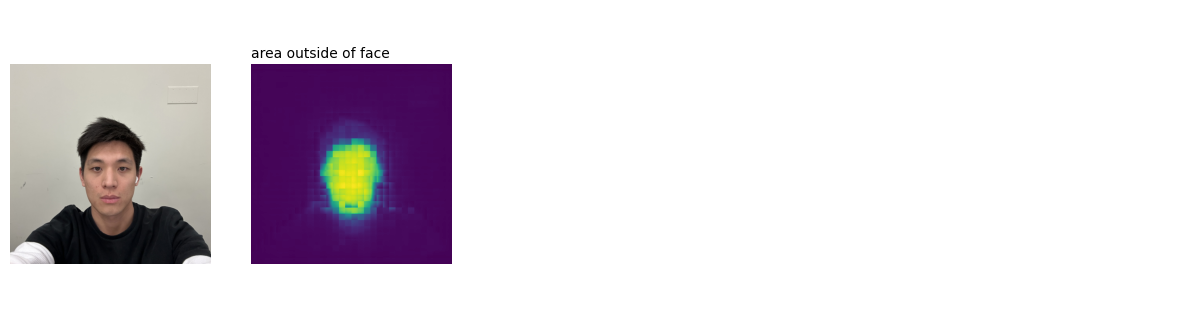

In [29]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];
print(preds.shape)

In [30]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [31]:
img2 = cv2.imread(filename)

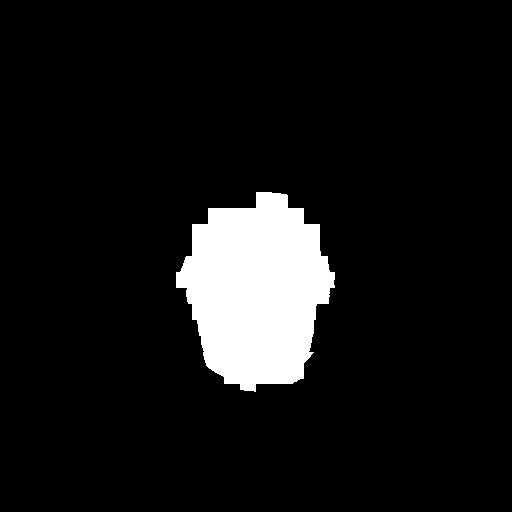

In [32]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [33]:
input_image = input_image
mask = Image.fromarray(bw_image)

In [34]:
from PIL import ImageOps

inverted_mask = ImageOps.invert(mask)

In [35]:
mask
# init_image

from google.colab import drive
drive.mount('/content/drive')

mask.save('/content/drive/MyDrive/ADV9207/01_face_output/mask_save/mask.jpg')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 7>:7                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/PIL/Image.py:2237 in save                                │
│                                                                                                  │
│   2234 │   │   │   │   # writer needs to go back and edit the written data.                      │
│   2235 │   │   │   │   fp = builtins.open(filename, "r+b")                                       │
│   2236 │   │   │   else:                                                                         │
│ ❱ 2237 │   │   │   │   fp = builtins.open(filename, "w+b")                                       │
│   2238 │   │                                                                                     │
│   2239 │   │   try:                                                                              │
│   2240 │   │   │   save_handler(self, fp, filename)                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

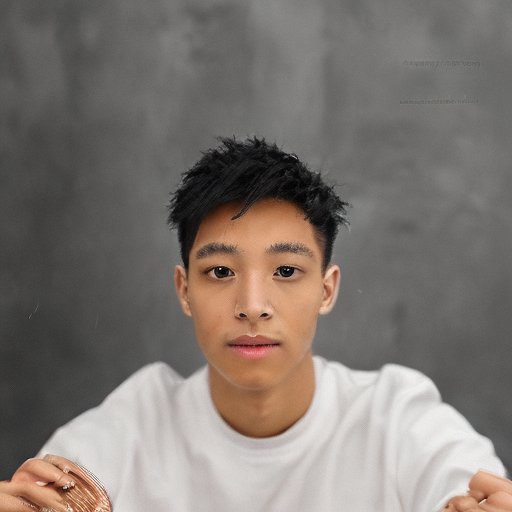

In [55]:
# maxCount = 2 # amount of img in grid
# generatedImages = []
# for count in range(maxCount):

from diffusers import StableDiffusionControlNetPipeline

controlnet = ControlNetModel.from_pretrained(
      "lllyasviel/sd-controlnet-canny", torch_dtype = torch.float16 

  )

imagesToGenerate = 1 
personName = "mqingBa1"

from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

  # pipe = DiffusionPipeline.from_pretrained("XpucT/Deliberate", torch_dtype=torch.float16)

pipe = DiffusionPipeline.from_pretrained("wavymulder/portraitplus", torch_dtype=torch.float16)
  # pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)

pipe.to("cuda")

  #loading in the trained weights
pipe.unet.load_attn_procs('/content/drive/MyDrive/ADV9207/04_fine_tuning/02_output/weights/', weight_name="pytorch_custom_diffusion_weights.bin")
pipe.load_textual_inversion('/content/drive/MyDrive/ADV9207/04_fine_tuning/02_output/weights/', weight_name=personName+".bin")

  #import ControlNet into the SD pipeline
pipe = StableDiffusionControlNetPipeline(**pipe.components, controlnet=controlnet)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

generator = torch.Generator(device = "cuda").manual_seed(24)
steps = 50
pipe.enable_model_cpu_offload()

  # images = pipe(prompt= " portrait+ style A photo of a "+ personName +"person,asian man, comically_chubby_cheeks=4:2, chubiness_chin=4:2, acne_scars=4:2, oily_skin=8:2, puffy_eyebags_1:2", negative_prompt="round nose, non-Asian, black-white, hat, open-mouth, mask, beard, multiple people, 3d, cgi, fake human, glasses, double_eye_yelid, a different person", num_inference_steps = steps, image = canny_image, generator = generator, guidance_scale= 7.5)
  # generatedImages.append(images.images[0])
images = pipe(prompt= " portrait+ style A photo of a "+ personName +" man, black hair, healthy-looking face, bright skins", 
              negative_prompt="honeycomb, blue eyes, white, grey, tatoo, dark skin, white shirt, hat, blurry, dead eyes, round nose, non-Asian, black-white, hat, open-mouth, mask, beard, multiple people, 3d, cgi, fake human, glasses, double_eye_yelid, a different person", num_inference_steps = steps, image = canny_image, generator = generator, guidance_scale= 7.5)

# grid = uaiDiffusers.imageGrid(generatedImages, 4)
# grid #showing grid of img
#image show
images.images[0].show() #showing img


In [56]:
#generate foreground body gesture w/ SD in-paint 

def GenerateBackground(foregroundImage, mask_, sdRepo = "stabilityai/stable-diffusion-2-inpainting", prompt_ = "A park",negPrompt_="Missing body", imagesToGenerate = 1, seed = 42, device="cuda"):
    from diffusers import StableDiffusionInpaintPipeline
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        sdRepo,
        torch_dtype=torch.float16,
    )
    pipe.to("cuda")
    prompt = prompt_
    generator = torch.Generator(device=device).manual_seed(seed)
    #image and mask_image should be PIL images.
    #The mask structure is white for inpainting and black for keeping as is
    image = pipe(prompt=prompt,negative_prompt=negPrompt_, image = foregroundImage, mask_image=mask_, num_images_per_prompt=imagesToGenerate).images

    return image

In [48]:
maxCount = 0
generatedImages = []
for count in range(maxCount):
  GenerateBackground_=GenerateBackground(images.images[0], inverted_mask, sdRepo = "stabilityai/stable-diffusion-2-inpainting", prompt_ = "photorealistic image of an asian man in plain black short-sleeve shirt eating ramen, frontal-lighting",negPrompt_="Missing body, background", imagesToGenerate = 1, seed = 42, device="cuda") 
  generatedImages.append(GenerateBackground_[0])
grid = uaiDiffusers.imageGrid(generatedImages, 1)
grid

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/uaiDiffusers/uaiDiffusers.py:247 in imageGrid            │
│                                                                                                  │
│   244 def imageGrid(imgs, rows, maxWidth = 1080):                                                │
│   245 │   from  PIL import Image                                                                 │
│   246 │   cols =  int(len(imgs)/rows)                                                            │
│ ❱ 247 │   w, h = imgs[0].size                                                                    │
│   248 │   grid = Image.new('RGB', size=(cols*w, rows*h))                                         │
│   249 │   grid_w, grid_h = grid.size                                                             │
│   250                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

  0%|          | 0/50 [00:00<?, ?it/s]

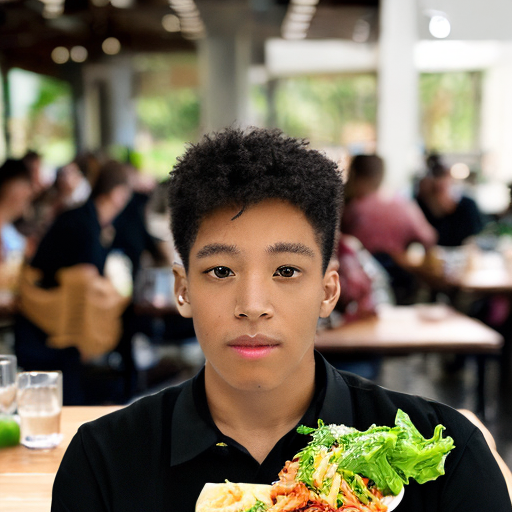

In [67]:
GenerateBackground_=GenerateBackground(images.images[0], inverted_mask, sdRepo = "stabilityai/stable-diffusion-2-inpainting", prompt_ = "photorealistic image of a man in black short-sleeve shirt eating locally-sourced healthy meal, frontal-lighting",negPrompt_="dead eyes, hat, things above head, grey tshirt, Missing body, background", imagesToGenerate = 1, seed = 42, device="cuda") 

GenerateBackground_[0]

In [ ]:
type(images.images[0])

PIL.Image.Image

In [ ]:
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

images.images[0].save('/content/drive/MyDrive/ADV9207/01_face_output/sample_image.jpg')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
